In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline


In [2]:
from transformers import (
    GPT2Config,
    GPT2Tokenizer,
    GPT2LMHeadModel,
)

/home/cgagne/cvar_generation/conda_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
modelname = '../models/pretrained/gpt2-large/'
config = GPT2Config.from_pretrained(modelname)
tokenizer = GPT2Tokenizer.from_pretrained(modelname)

In [116]:
import sys
sys.path.append('../')
from rl_learner import TD_Learner
import torch
import pickle
device = 'cpu'
import sys
sys.path.append('../')

from cvar_helpers import calc_cvar_from_samples
from train_rl_batch_sentence_chains import average_states_by_period

### Loading Training Data 

In [117]:
file = '../data/results/sentence_chains_I_1/generations_using.txt'
f = open(file, "r")
sentences = f.readlines()
sentences = np.array([s.replace('\n','') for s in sentences])
rewards =  [np.array(s.split('r=')[-1].split(',')).astype('float') for s in sentences]

# removing some bad examples #
rewards2 = []
sentences2 = []
for r,s in zip(rewards, sentences):
    if len(r)!=3:
        pass
    else:
        rewards2.append(r)
        sentences2.append(s)
sentences = sentences2
rewards = np.array(rewards2)
state_rewards = rewards
rewards = rewards.sum(axis=1)

assert len(sentences) == len(rewards)

In [119]:
print(len(sentences))

9991


In [118]:
print(sentences[0:5])
print(rewards[0:5])
print(state_rewards[0:5])

['I woke up early. I brushed my teeth. I packed up my sweatpants, sneakers and two golf shorts. I went home and the dogs were asleep and the cat was dead. I puked all over my living room floor and waited. p=0.151,0.139,0.229 r=0.142,-0.727,-0.865', "I woke up early. I brushed my teeth. I squeezed my husband's hand, because some — it just doesn't have to be personal again. And I just thought it was really good I got out of here. And then I didn't have a choice. p=0.283,0.285,0.365 r=0.049,0.923,-0.415", 'I woke up early. I brushed my teeth. I went back to my room. Picked up the phone. Went to bed. p=0.344,0.54,0.133 r=0.036,0.069,0.02', 'I woke up early. I brushed my teeth. I washed my hands. And then I was done. The doors were unlocked. p=0.18,0.547,0.317 r=0.139,-0.1,0.305', "I woke up early. I brushed my teeth. I slept. I went to clean the bathtub. And when I woke up again, it was like I couldn't fall asleep or stay asleep. p=0.373,0.054,0.023 r=-0.253,0.023,-0.625"]
[-1.45   0.557  

(array([  36.,  163.,  508., 1359., 2669., 3172., 1387.,  510.,  162.,
          25.]),
 array([-2.749, -2.181, -1.613, -1.045, -0.477,  0.091,  0.659,  1.227,
         1.795,  2.363,  2.931]),
 <BarContainer object of 10 artists>)

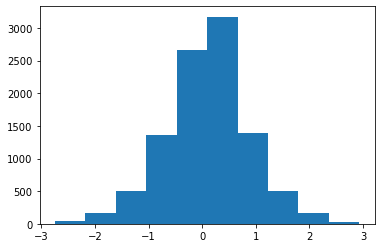

In [128]:
plt.hist(rewards)

### Load the Quantile Learner

In [123]:
epoch=47
#epoch=99
hidden_dim =102
hidden_dim =100
n_quantiles = 10
prompt_enc = ''
filename='../data/results/sentence_chains_I_1/'
filename+=f'quantile_learner_{hidden_dim}_0.1{prompt_enc}/log_quantile_learner_epoch{epoch}.pkl'

Z_network = TD_Learner(config.n_embd, n_quantiles, hidden_dim=hidden_dim)
Z_network.load_state_dict(torch.load(filename.replace('log_',''),map_location=torch.device('cpu')))

log = pickle.load(open(filename,'rb'))
loss = np.array(log['loss'])
epoch = np.array(log['epoch'])

### Training Loss

Text(0.5, 0, 'epochs')

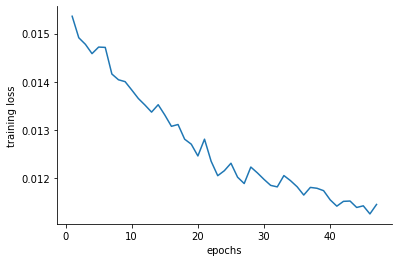

In [111]:
plt.plot(epoch, loss)
sns.despine()
plt.ylabel('training loss')
plt.xlabel('epochs')

### Stored Examples 

- for 100, I was not storing the examples correctly

In [112]:
examples = ['I puked all over my living room floor and waited.',
                        "You're dirty.",
                        'I took the stupid potty training class and passed out on the mat.',
                        'My knuckles are tired.',
                        'I got on a park bench and happily listened to Mozart and Praxis performed.',
                        'I was, of course, all six packer eyes.',
                        "That was his New Year's Resolution: health.",
                        "It was very nice.",
                        "The benefits of moving early always seem pretty obvious to me.",
                        "The sun was shining and I'd made it to campus on time."]

In [113]:
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
taus

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

[-1.746, -1.746, -1.746, -1.746, -1.746, -1.746, -1.746, -1.746, -1.746, -1.746]
[-1.606, -1.606, -1.606, -1.606, -1.606, -1.606, -1.606, -1.606, -1.606, -1.606]
[-1.746, -1.746, -1.746, -1.746, -1.746, -1.746, -1.746, -1.746, -1.746, -1.746]


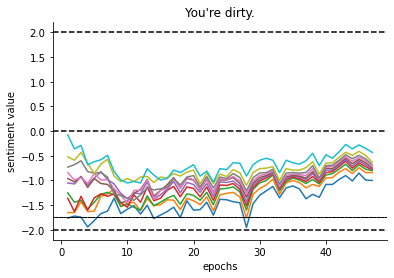

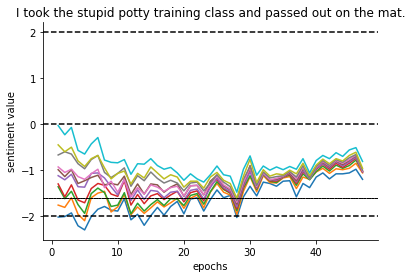

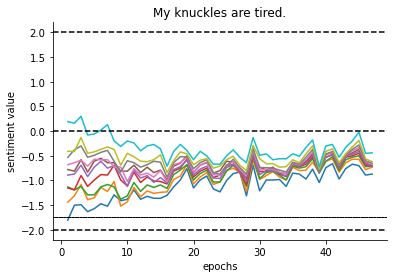

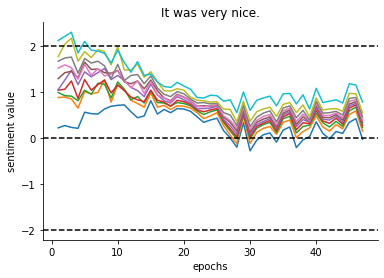

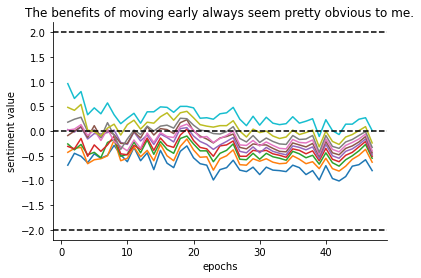

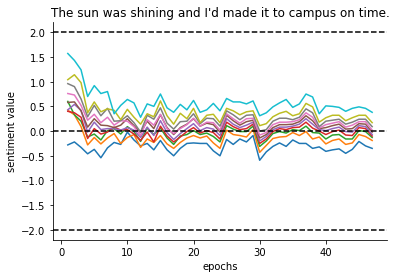

In [114]:
for example in examples:
    
    if example in log.keys():
        plt.figure()
        plt.plot(epoch, np.array(log[example]))
        sns.despine()
        plt.axhline(y=-2, color='k', linestyle='--')
        plt.axhline(y=0, color='k', linestyle='--')
        plt.axhline(y=2, color='k', linestyle='--')
        plt.ylabel('sentiment value')
        plt.xlabel('epochs')
        plt.title(example)

        sel = np.array([example in s for s in sentences]).astype('bool')
        if np.sum(sel)>0:
            thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
            print(thetas)
            for theta in thetas:
                    plt.axhline(y=theta, linestyle='--', color='k', linewidth=0.5)

### Examples from training set

In [115]:
model = GPT2LMHeadModel.from_pretrained(modelname)
device='cpu'

In [141]:
examples = ['I puked all over my living room floor and waited.',
                        "You're dirty.",
                        'I took the stupid potty training class and passed out on the mat.',
                        'My knuckles are tired.',
                        'I got on a park bench and happily listened to Mozart and Praxis performed.',
                        'I was, of course, all six packer eyes.',
                        "That was his New Year's Resolution: health.",
                        "It was very nice.",
                        "The benefits of moving early always seem pretty obvious to me.",
                        "The sun was shining and I'd made it to campus on time.",
           'I got dressed.',
           'I took my shower.',
           'I went to the bathroom.']

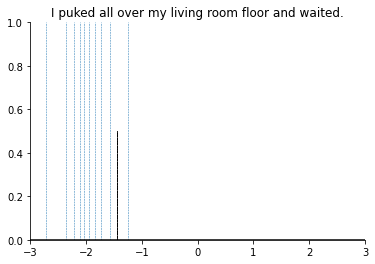

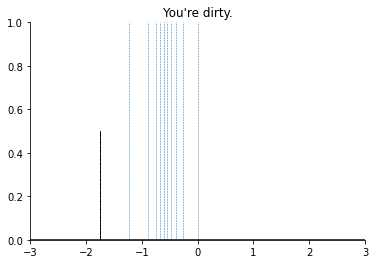

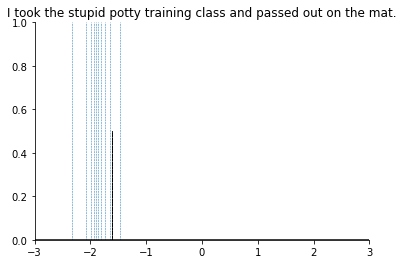

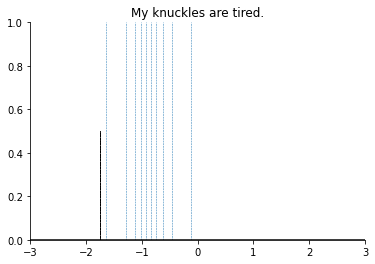

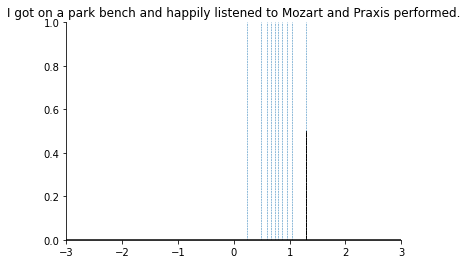

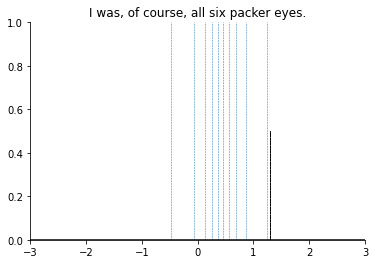

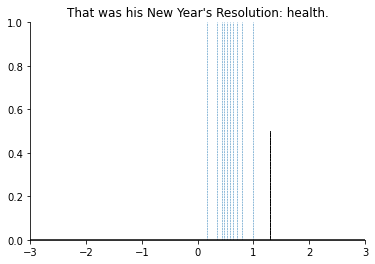

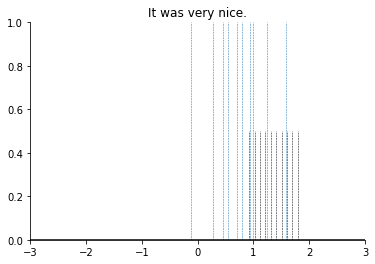

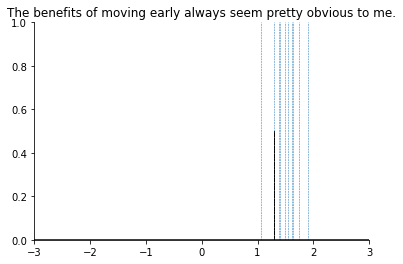

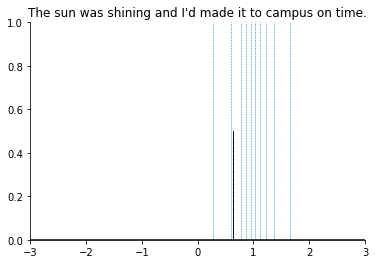

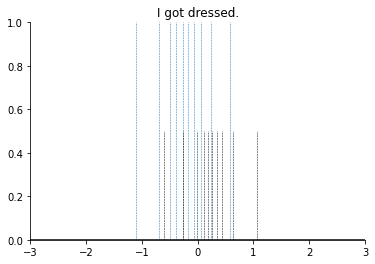

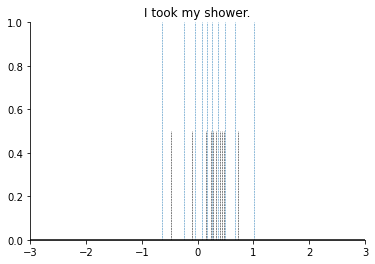

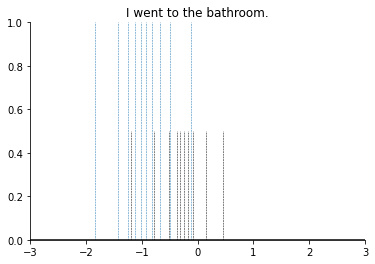

In [142]:
for example in examples:
    
    inputs = tokenizer(example, return_tensors='pt').to(device)
    with torch.no_grad():
        input_ids = inputs['input_ids']
        mask = inputs['attention_mask']
        output = model(input_ids=input_ids,
                       attention_mask=mask,
                       output_hidden_states=True)
        states = output['hidden_states'][-1]
        states, _ = average_states_by_period(states, mask.unsqueeze(-1), input_ids, device,
                                            n_periods=example.count('.'), period_tok_id=13, pad_tok_id=50256)
        
        theta_hats = Z_network(states).detach().cpu().numpy().round(2)
        theta_hats_last = theta_hats[:,-1,:].squeeze()
    #print(theta_hats_last)

    plt.figure()
    
    for theta in theta_hats_last:
        plt.axvline(x=theta, linestyle='--', linewidth=0.5)

    sel = np.array([example in s for s in sentences]).astype('bool')
    if np.sum(sel)>0:
        thetas = [np.quantile(rewards[sel].squeeze(), q) for q in taus]
        for theta in thetas:
            plt.axvline(x=theta, ymax=0.5, linestyle='--', linewidth=0.5, color='k')

    plt.xlim([-3,3])
    plt.axhline(y=0., color='k')
    sns.despine()
    plt.title(example)

### Plotting Distributions

In [149]:
sentences_cvar = {}
rewards_cvar = {}
alphas = [0.05, 0.2]
top_k =10
prompt_enc = ''
for alpha in alphas:

    file = f'../data/results/sentence_chains_I_1/generations_{alpha}.txt'
    f = open(file, "r")
    sentences_cvar[alpha] = np.array([s.replace('\n','') for s in f.readlines()])
    rewards_cvar[alpha] =  []
    for s in sentences_cvar[alpha]:
        r = np.sum(np.array(s.split('r=')[-1].split(',')).astype('float'))
        rewards_cvar[alpha].append(r)

    rewards_cvar[alpha]=np.array(rewards_cvar[alpha])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


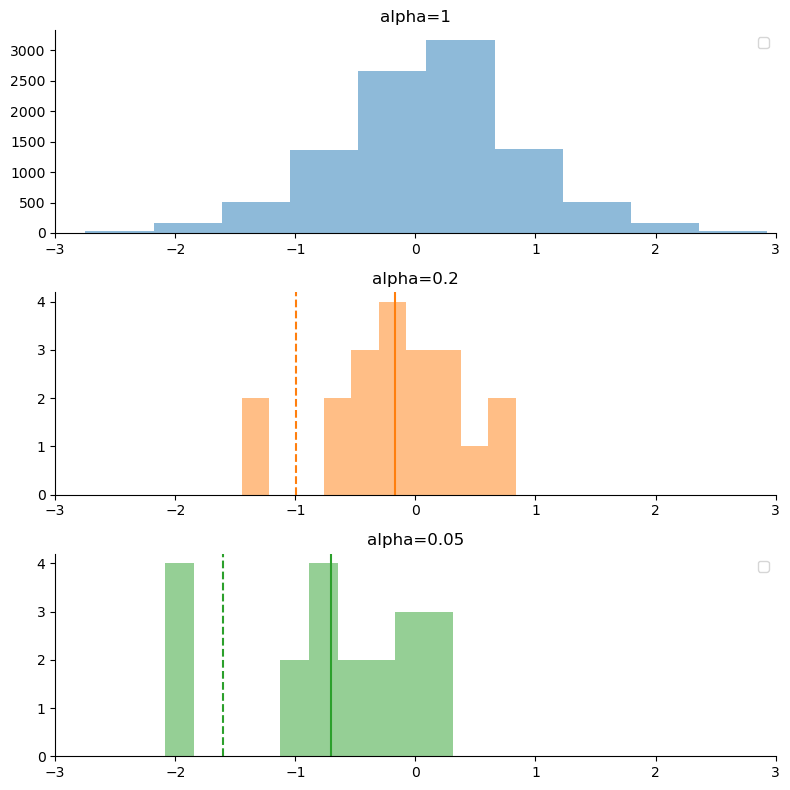

In [150]:

# full distribution
stem = ""
sel = np.array([s.startswith(stem) for s in sentences]).astype('bool')
fig,axes = plt.subplots(len(alphas)+1, 1, figsize=(8,4*len(alphas)), dpi=100)

plt.sca(axes[0])
plt.hist(rewards[sel], alpha=0.5, label=f'{stem}', density=False)

plt.legend()
sns.despine()
plt.xlim([-3,3])
plt.title(f'alpha=1')

# alphas 
for a, alpha in enumerate(alphas[::-1]):
    
    plt.sca(axes[a+1]) 
    sel_cvar = np.array([s.startswith(stem) for s in sentences_cvar[alpha]]).astype('bool')
    plt.hist(rewards_cvar[alpha][sel_cvar], alpha=0.5, color=sns.color_palette()[a+1],
             label=f'{stem}',density=False)
    
    _, cvar = calc_cvar_from_samples(rewards[sel], alpha)
    mean = np.nanmean(rewards_cvar[alpha][sel_cvar])
    plt.axvline(x=cvar, color=sns.color_palette()[a+1], linestyle='--')
    plt.axvline(x=mean, color=sns.color_palette()[a+1])
    plt.xlim([-3,3])
    plt.title(f'alpha={alpha}')
    
plt.legend()
plt.tight_layout()

### Printing Examples

In [151]:
n_quantiles = 10
taus = (2 * np.arange(n_quantiles) + 1) / (2.0 * n_quantiles)
alpha_set = list(np.append(np.insert(taus, 0, 0), 1)) # add zero, one
taus_set = list(taus)
taus_set

[0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]

In [156]:
alpha_storage = {}
p_storage = {}
pd_storage = {}
sentences_storage = {}
rewards_storage = {}
cvar_storage = {}
quantile_storage = {}
top_k=10

for alpha in [0.05]:

    file = f'../data/results/sentence_chains_I_1/cvar_output_{alpha}.pkl'
    
    loaded = pickle.load(open(file,'rb'))
    alpha_storage[alpha] = loaded['alpha_storage']
    p_storage[alpha] = loaded['p_storage']
    pd_storage[alpha] = loaded['pd_storage']
    sentences_storage[alpha] = loaded['sentences_storage']
    rewards_storage[alpha] = loaded['rewards_storage']
    cvar_storage[alpha] = loaded['cvar_storage']
    quantile_storage[alpha] = loaded['quantile_storage']

In [160]:
alpha =0.05
for s, (sentence,r) in enumerate(zip(sentences_storage[alpha], rewards_storage[alpha])):
    if sentence not in sentences:
        print(s, sentence, np.round(r,2), np.round(np.sum(r),2))
        print()

0 ["I woke up early. Then I brushed my teeth. I had to go to the bathroom. I'm not particularly fond of my teeth. I woke up early. p=0.052,0.956,0.827 r=-0.519,-0.885,0.497\n"] [-0.52 -0.88  0.5 ] -0.91

1 ['I woke up early. Then I brushed my teeth. I walked to the supermarket to buy bread. I was ready to head home. But I was stopped by a policeman. p=0.46,0.809,0.1 r=0.004,0.015,-0.43\n'] [ 0.    0.01 -0.43] -0.41

2 ['I woke up early. Then I brushed my teeth. I took a shower. Then I got dressed. I went to the party. p=0.04,0.076,0.811 r=0.091,0.065,0.141\n'] [0.09 0.06 0.14] 0.3

3 ['I woke up early. Then I brushed my teeth. Then I felt the water hit the back of my head and I started to shiver. My neck felt a bit numb. And then I just started to calm down. p=0.889,0.235,0.088 r=-0.562,-0.597,0.331\n'] [-0.56 -0.6   0.33] -0.83

4 ['I woke up early. Then I brushed my teeth. Then I went for a run. I was running. I got back and went to the bathroom. p=0.201,0.737,0.304 r=0.187,-0.065,-0